In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()

    prediction = []

    for x, _ in loader:
        output = model(x.to(device)).cpu()

        prediction.append(torch.argmax(output, dim=1))

    prediction = torch.cat(prediction)

    return prediction


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()

    prediction = []

    for iteration in range(iterations):
        single_prediction = []

        for x, _ in loader:
            output = model(x.to(device)).cpu()

            single_prediction.append(output)

        prediction.append(torch.vstack(single_prediction))

    prediction = torch.argmax(torch.mean(torch.stack(prediction), dim=0), dim=1)

    return prediction


In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm


def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


def train(
        model: nn.Module,
        data_loader: DataLoader,
        optimizer: Optimizer,
        loss_fn,
        device: torch.device,
) -> tuple[float, float]:
    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total


@torch.inference_mode()
def evaluate(
        model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Evaluate"):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total


def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " accuracy")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [8]:
from torch.optim.lr_scheduler import StepLR


def whole_train_valid_cycle(
        model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        scheduler.step()

        if valid_accuracy >= threshold:
            break


def main(func, threshold, title):
    set_seed(0xDEADF00D)

    dataset = CIFAR10("Data/cifar10", train=True, download=True, transform=T.ToTensor())

    means = (dataset.data / 255).mean(axis=(0, 1, 2))
    stds = (dataset.data / 255).std(axis=(0, 1, 2))

    train_transforms = T.Compose(
        [
            T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomAdjustSharpness(sharpness_factor=2),
            T.ToTensor(),
            T.Normalize(mean=means, std=stds),
        ]
    )

    test_transforms = T.Compose([T.ToTensor(), T.Normalize(mean=means, std=stds)])

    dataset_train = CIFAR10(
        "Data/cifar10", train=True, download=True, transform=train_transforms
    )
    dataset_valid = CIFAR10(
        "Data/cifar10", train=False, download=True, transform=test_transforms
    )

    train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
    valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = func().to(device)

    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

    loss_fn = nn.CrossEntropyLoss()

    whole_train_valid_cycle(
        model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
    )

    torch.save(model.state_dict(), "model.pt")

    dataset_valid_tta = CIFAR10("Data/cifar10", train=False, download=True, transform=train_transforms)
    valid_tta_loader = DataLoader(dataset_valid_tta, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

    torch.save(predict_tta(model, valid_tta_loader, device, iterations=20), "prediction.pt")


In [10]:
# файл для сдачи
import torch.nn as nn


def create_advanced_conv_cifar():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.2),

        nn.Flatten(),

        nn.Linear(4 * 4 * 128, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(512, 100)
    )


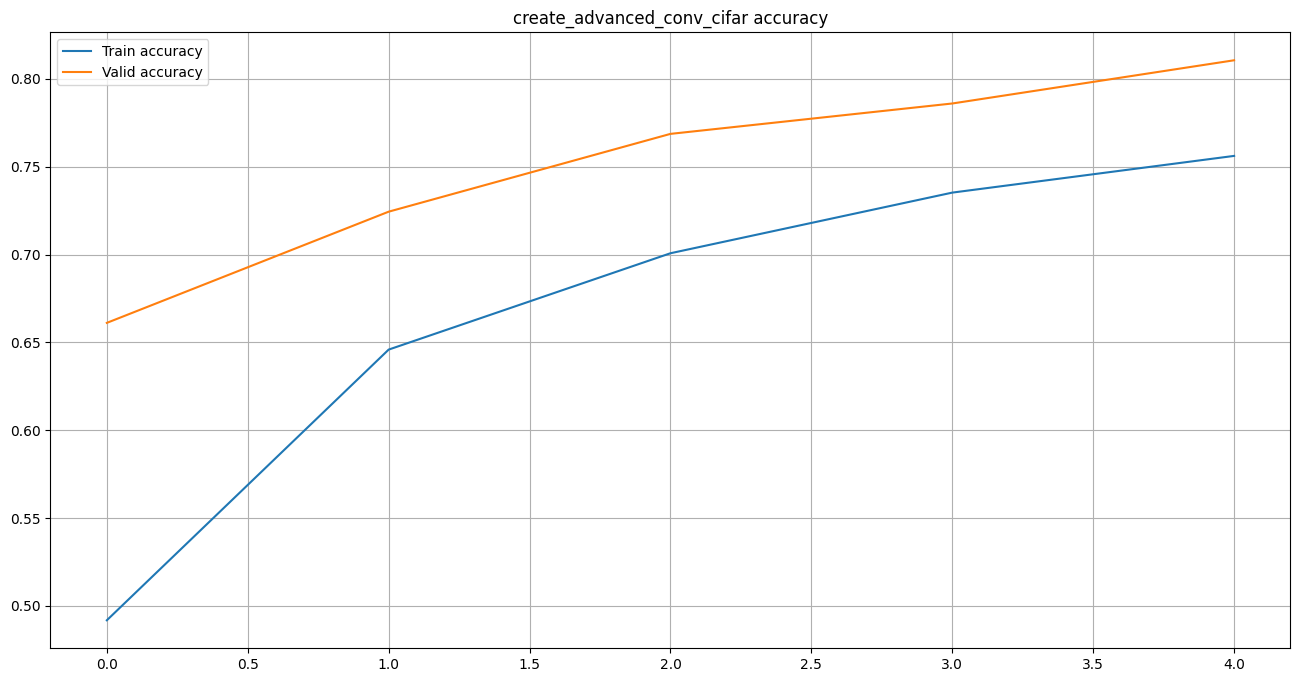

Train:  58%|█████▊    | 227/391 [02:06<01:09,  2.35it/s]

In [ ]:
main(create_advanced_conv_cifar, 0.88, 'create_advanced_conv_cifar')